In [128]:
import json

text, reference = zip(*json.load(open('../../data/processed/cnn-dm_test.json', 'r')))
reference = list(reference)

In [126]:
original = json.load(open('../../original_summary.json', 'r'))

# Frozen

## ROUGE

In [ ]:
from rouge import Rouge

rouge = Rouge()
avgs = []
for epoch in range(10):
    generated = json.load(open(f'../../summary/run-12_epoch{epoch}_end', 'r'))
    # scores = rouge.get_scores(generated, reference)
    avg = rouge.get_scores(generated, reference, avg=True)
    avgs.append(avg)

In [ ]:
r1 = [s['rouge-1']['f'] for s in avgs]
r2 = [s['rouge-2']['f'] for s in avgs]
rl = [s['rouge-l']['f'] for s in avgs]

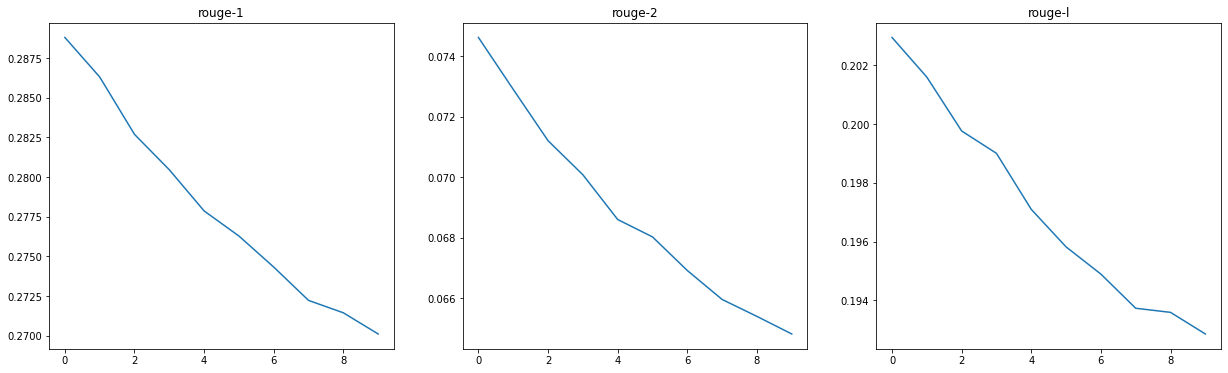

In [ ]:
import matplotlib.pyplot as plt

fig, axs  = plt.subplots(1, 3)
fig.set_size_inches(21, 6)
axs = axs.flatten()
axs[0].plot(r1)
axs[0].set_title('rouge-1')
axs[1].plot(r2)
axs[1].set_title('rouge-2')
axs[2].plot(rl)
axs[2].set_title('rouge-l')
plt.show()

## METEOR

can try stem_match

In [ ]:
# import nltk
# nltk.download('omw-1.4')
from nltk.translate.meteor_score import single_meteor_score

avgs = []
for epoch in range(10):
    generated = json.load(open(f'../../summary/run-12_epoch{epoch}_end', 'r'))
    scores = []
    for i in range(len(generated)):
        score = single_meteor_score(reference[i].split(), generated[i].split())
        scores.append(score)
    avgs.append(sum(scores)/len(scores))
    print(epoch)


0
1
2
3
4
5
6
7
8
9


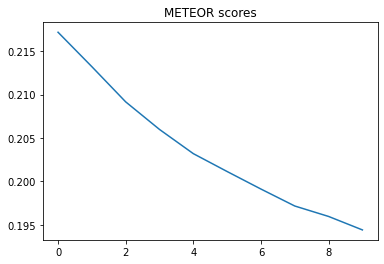

In [ ]:
plt.plot(avgs)
plt.title('METEOR scores')
plt.show()

## SUPERT adaptation

In [ ]:
import nltk
# nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import re

You must run a tf idf count of the corpus beforehand
Preprocess (regex pattern and .lower) is taken from 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [ ]:
corpus, _ = zip(*json.load(open('../../data/processed/cnn-dm_sent_test.json', 'r')))

In [ ]:
def supert_summaries(corpus, k=3, beta=3):
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit(corpus)
    summaries = []
    for article in corpus:
        sentences = article.split(" | ")
        N = len(sentences)
        
        bar = []
        for i, sent in enumerate(sentences):
            split_sent = re.findall(r"(?u)\b\w\w+\b", sent)
            if len(split_sent) == 0:
                continue
            pi = 1 / (1 + (i / (N - i))**beta)
            tfidf_sum = sum([tfidf.vocabulary_[w.lower()] for w in split_sent])   # Sum of tfidf scores of each word
            score = pi * tfidf_sum / len(split_sent)
            bar.append((score, sent))
        top_k = list(map(lambda k: k[1], sorted(bar, key=lambda k: k[0], reverse=True)[:k]))
        summaries.append(' '.join(top_k))
    return summaries
summaries = supert_summaries(corpus)

In [ ]:
import string
def overlap(generated, reference):
    table = str.maketrans('', '', string.punctuation)
    counts = []
    for i in range(len(reference)):
        gen = generated[i].translate(table).split() # removes punctuation
        summ = reference[i].split()
        count = 0
        for word in gen:
            count += word in summ
        counts.append(count/len(gen))
    return counts

In [ ]:
avgs = []
for epoch in range(10):
    generated = json.load(open(f'../../summary/run-12_epoch{epoch}_end', 'r'))
    counts = overlap(generated, summaries)
    avgs.append(sum(counts) / len(counts))

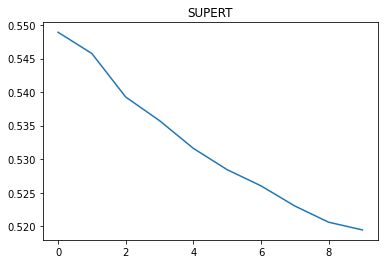

In [ ]:
plt.plot(avgs)
plt.title("SUPERT")
plt.show()

In [ ]:
print(sum(counts) / len(counts))

0.5316196289492121


# Unfrozen

In [129]:
files = ['0_step49', '0_step99', '0_step149', '0_step199', '0_step249', '0_end', '1_step49', '1_step99']

## ROUGE

In [48]:
from rouge import Rouge

rouge = Rouge()
avgs = [rouge.get_scores(original, reference, avg=True)]
for file in files:
    generated = json.load(open(f'../../summary-unfrozen/epoch{file}.json', 'r'))
    # scores = rouge.get_scores(generated, reference)
    avg = rouge.get_scores(generated, reference, avg=True)
    avgs.append(avg)

In [49]:
r1 = [s['rouge-1']['f'] for s in avgs]
r2 = [s['rouge-2']['f'] for s in avgs]
rl = [s['rouge-l']['f'] for s in avgs]

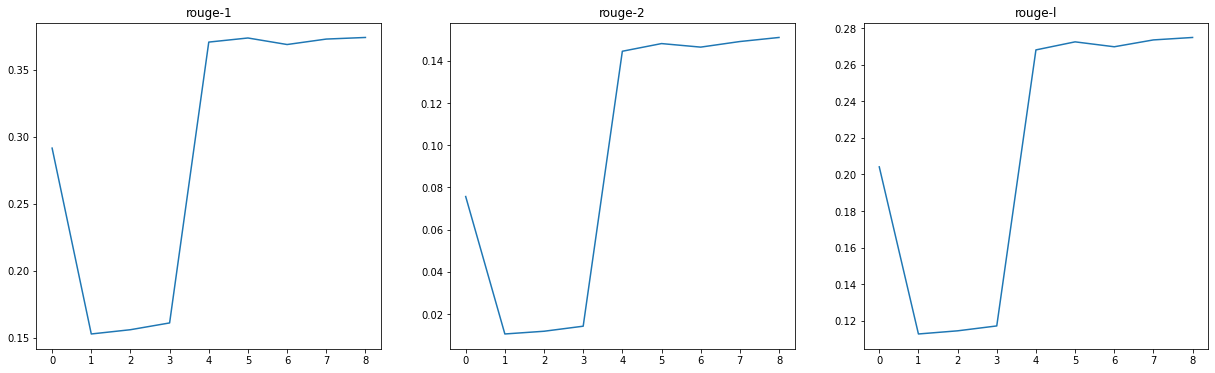

In [50]:
import matplotlib.pyplot as plt

fig, axs  = plt.subplots(1, 3)
fig.set_size_inches(21, 6)
axs = axs.flatten()
axs[0].plot(r1)
axs[0].set_title('rouge-1')
axs[1].plot(r2)
axs[1].set_title('rouge-2')
axs[2].plot(rl)
axs[2].set_title('rouge-l')
plt.show()

## METEOR

can try stem_match

In [51]:
# import nltk
# nltk.download('omw-1.4')
from nltk.translate.meteor_score import single_meteor_score

og_scores = []
for i in range(len(original)):
    og_score = single_meteor_score(reference[i].split(), original[i].split())
    og_scores.append(og_score)

avgs = [sum(og_scores) / len(og_scores)]
for file in files:
    generated = json.load(open(f'../../summary-unfrozen/epoch{file}.json', 'r'))
    scores = []
    for i in range(len(generated)):
        score = single_meteor_score(reference[i].split(), generated[i].split())
        scores.append(score)
    avgs.append(sum(scores)/len(scores))

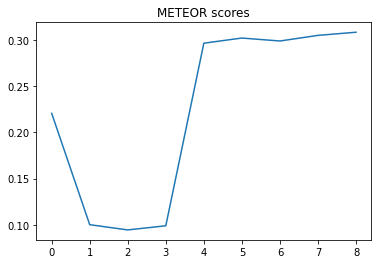

In [52]:
plt.plot(avgs)
plt.title('METEOR scores')
plt.show()

## SUPERT adaptation

In [4]:
import nltk
# nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import numpy as np
import json

You must run a tf idf count of the corpus beforehand
Preprocess (regex pattern and .lower) is taken from 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [5]:
corpus, _ = zip(*json.load(open('../../data/processed/cnn-dm_sent_test.json', 'r')))

In [115]:
def tfidf_score(sentence, vocabulary):
    split_sent = re.findall(r"(?u)\b\w\w+\b", sentence)
    if len(split_sent) == 0:
        return 0
    tfidf_sum = sum([vocabulary[w.lower()] for w in split_sent])
    return tfidf_sum

def importance(sentences, vocab):
    tfidf_sum = np.array([tfidf_score(sent, vocab) for sent in sentences])
    return tfidf_sum

def redundant_score(sent, summary, vocab):
    split_sent = re.findall(r"(?u)\b\w\w+\b", sent)
    if len(split_sent) == 0:
        return 0
    redundant = sum([vocab[w.lower()] for w in split_sent if w in summary])
    return redundant

def redundancy(sentences, summary, vocab):
    if len(summary) == 0:
        return 0
    summ = ' '.join(summary).split()
    redundancy_scores = np.array([redundant_score(sent, summ, vocab) for sent in sentences])
    return redundancy_scores

In [118]:
def supert_summaries(corpus, k=3, c=0.75, beta=3):
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit(corpus)
    summaries = []
    indices = []
    for article in corpus:
        sentences = np.array(article.split(" | "))
        N = len(sentences)

        i = np.arange(N)
        pi = 1 / (1 + (i / (N - i))**beta)
        
        summary = []
        kept = []
        
        while len(summary) < k and len(summary) < N:
            scores = pi * (c * importance(sentences, tfidf.vocabulary_) - (1 - c) * redundancy(sentences, summary, tfidf.vocabulary_))
            order = (-scores).argsort()
            t = 0
            while order[t] in kept:
                t += 1
            idx = order[t]
            kept.append(idx)
            summary.append(sentences[idx])
        summaries.append(' '.join(summary))
        indices.append(kept)
    return summaries, indices

In [113]:
import matplotlib.pyplot as plt

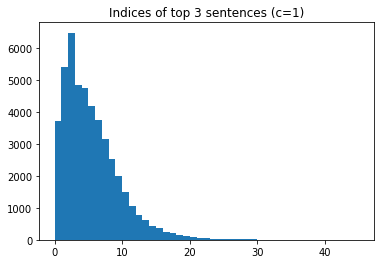

In [119]:
summaries1, indices1 = supert_summaries(corpus, c=1)
plt.hist(sum(indices1, []), bins=max(sum(indices1, [])))
plt.title('Indices of top 3 sentences (c=1)')
plt.show()

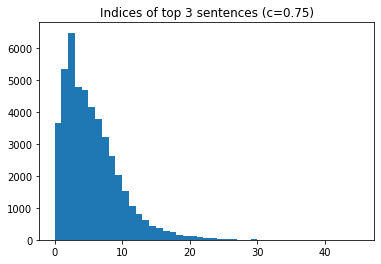

In [120]:
summaries, indices = supert_summaries(corpus)
plt.hist(sum(indices, []), bins=max(sum(indices, [])))
plt.title('Indices of top 3 sentences (c=0.75)')
plt.show()

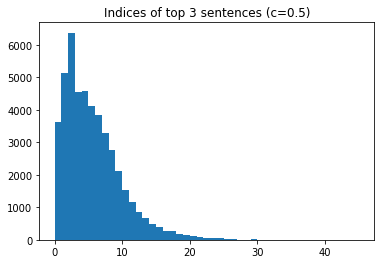

In [121]:
summaries05, indices05 = supert_summaries(corpus, c=0.5)
plt.hist(sum(indices05, []), bins=max(sum(indices05, [])))
plt.title('Indices of top 3 sentences (c=0.5)')
plt.show()

In [124]:
import string
def overlap(generated, reference):
    table = str.maketrans('', '', string.punctuation)
    counts = []
    for i in range(len(reference)):
        gen = generated[i].translate(table).split() # removes punctuation
        summ = reference[i].split()
        count = 0
        for word in gen:
            count += word in summ
        counts.append(count/len(gen))
    return counts

In [130]:
og_count = overlap(original, summaries)
avgs = [sum(og_count) / len(og_count)]
for file in files:
    generated = json.load(open(f'../../summary-unfrozen/epoch{file}.json', 'r'))
    counts = overlap(generated, summaries)
    avgs.append(sum(counts) / len(counts))

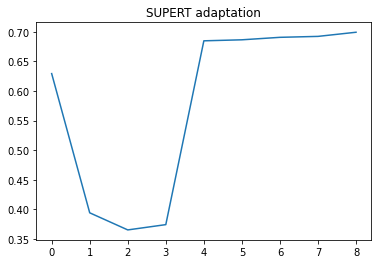

In [131]:
plt.plot(avgs)
plt.title("SUPERT adaptation")
plt.show()

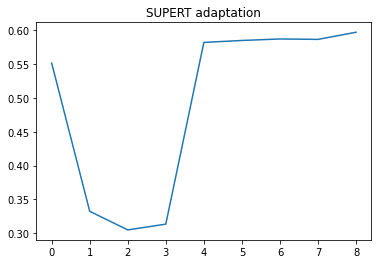

In [59]:
plt.plot(avgs)
plt.title("SUPERT adaptation")
plt.show()

# Investigating average length

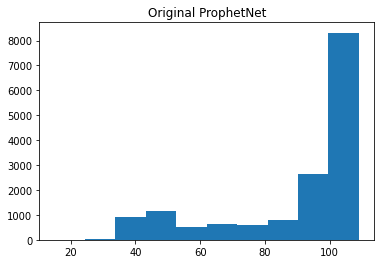

In [62]:
plt.hist([len(x.split()) for x in original])
plt.title("Original ProphetNet")
plt.show()

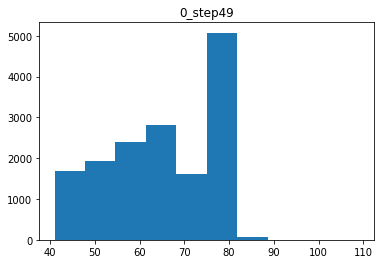

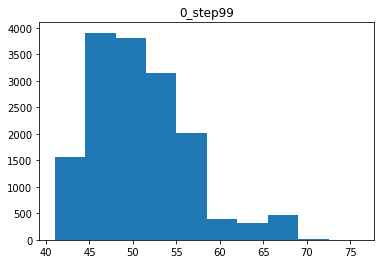

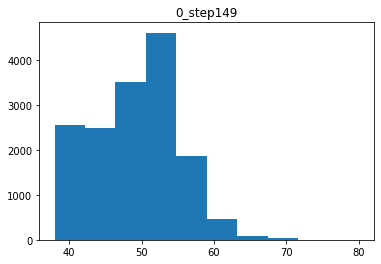

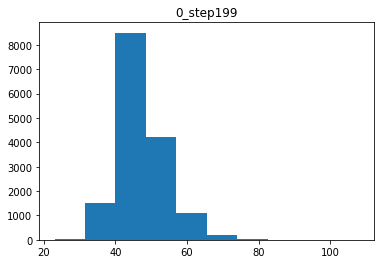

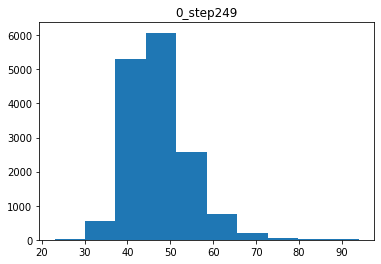

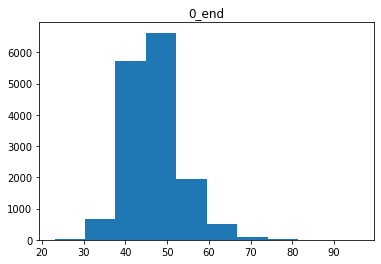

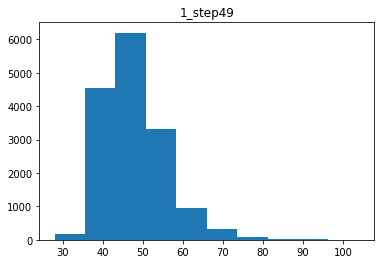

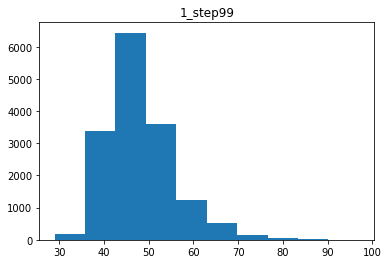

In [64]:
for file in files:
    generated = json.load(open(f'../../summary-unfrozen/epoch{file}.json', 'r'))
    plt.hist([len(x.split()) for x in generated])
    plt.title(file)
    plt.show()